<a href="https://www.kaggle.com/code/parisrohan/text-feature-cleaning-and-generation?scriptVersionId=101376155" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


In [2]:
#Load required libraries
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
pd.pandas.set_option('display.max_columns',None)

In [3]:
#Load training data
df_data=pd.read_csv('/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv')
df_data.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [4]:
df_data.columns

Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')

In [5]:
#Rename the columns to get a better sense of data
df_data.rename(columns=
    {
        '2401':'Tweet_ID',
        'Borderlands':'Topic',
        'Positive':'Sentiment',
        'im getting on borderlands and i will murder you all ,':'Tweet'
    },inplace=True 
)

df_data.head()

,Tweet_ID,Topic,Sentiment,Tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [6]:
#shape of data
df_data.shape

(74681, 4)

In [7]:
#percentage of missing data
(df_data.isnull().sum()/len(df_data))*100

Tweet_ID     0.000000
Topic        0.000000
Sentiment    0.000000
Tweet        0.918574
dtype: float64

In [8]:
#As only 0.91% of data in Tweet features are null we will drop them
df_data.dropna(axis=0,inplace=True)

In [9]:
#check percentage of missing data after dropping missing features
(df_data.isnull().sum()/len(df_data))*100

Tweet_ID     0.0
Topic        0.0
Sentiment    0.0
Tweet        0.0
dtype: float64

In [10]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73995 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet_ID   73995 non-null  int64 
 1   Topic      73995 non-null  object
 2   Sentiment  73995 non-null  object
 3   Tweet      73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.8+ MB


In [11]:
print('Distinct Values: \n')
col=['Topic','Sentiment']
for i in col:
    print(i,'->')
    print(df_data[i].value_counts())
    print('\n')

Distinct Values: 

Topic ->
MaddenNFL                            2377
LeagueOfLegends                      2377
CallOfDuty                           2376
Verizon                              2365
TomClancysRainbowSix                 2364
Facebook                             2362
Microsoft                            2361
Dota2                                2359
WorldOfCraft                         2357
ApexLegends                          2353
NBA2K                                2343
CallOfDutyBlackopsColdWar            2343
FIFA                                 2324
johnson&johnson                      2324
TomClancysGhostRecon                 2321
Battlefield                          2316
Overwatch                            2316
GrandTheftAuto(GTA)                  2293
HomeDepot                            2292
PlayStation5(PS5)                    2291
Hearthstone                          2286
CS-GO                                2284
Xbox(Xseries)                        2283
Border

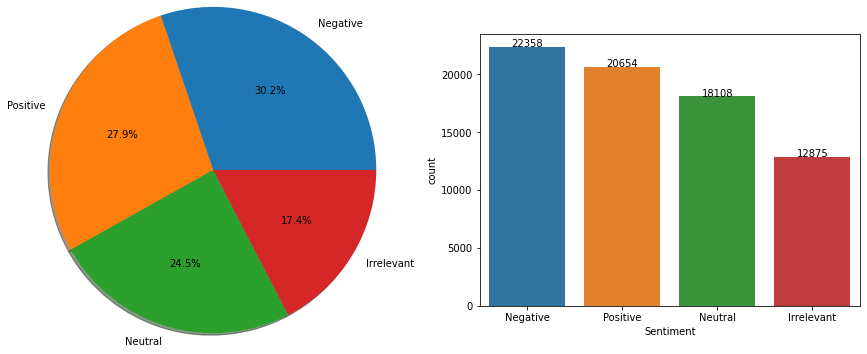

In [12]:
#Visualizing Sentiment feature - Target feature
plt.figure(figsize=(15,5))

#plot pie chart
plt.subplot(1,2,1)
label = df_data['Sentiment'].value_counts().index
label_count = df_data['Sentiment'].value_counts().values
plt.pie(data=df_data, x=label_count, labels=label, autopct='%1.1f%%', shadow=True, radius=1.5)

#plot countplot
plt.subplot(1,2,2)
ax = sns.countplot(x='Sentiment', data=df_data, order=label)
for p in ax.patches:
    height=p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2),
    y=height+0.2,ha='center',s='{:.0f}'.format(height))
plt.show()

In [13]:
#Get the count of words in each tweet
df_data['Tweet_word_count']=df_data['Tweet'].apply(lambda x: len(x.split()))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

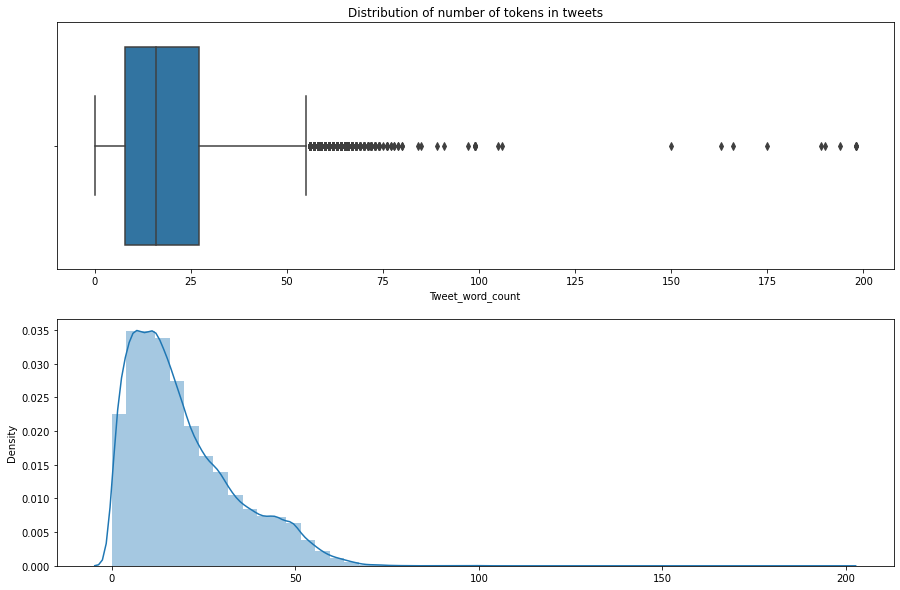

In [14]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.boxplot(x=df_data['Tweet_word_count'])
plt.title(('Distribution of number of tokens in tweets'))

plt.subplot(2,1,2)
sns.distplot(x=df_data['Tweet_word_count'])

Note:
* The mean length of tokens is around 23.
* The distribution is positively skewed.

In [15]:
#Extreme outliers
extreme_outliers = df_data['Tweet'][df_data['Tweet_word_count']>125]

for i in extreme_outliers.index:
    print(i,'Tweet Sentiment: ',df_data['Sentiment'][i])
    print(extreme_outliers[i])
    print('\n')

1825 Tweet Sentiment:  Neutral
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


8545 Tweet Sentiment:  Positive
I REALLY HAVE THE OVERWATCH RN GAME. SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEA SEE E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E E


10453 Tweet Sentiment:  Positive
_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

In [16]:
#Get count of characters in each tweet excluding the whitespaces
df_data['Tweet_char_count']=df_data['Tweet'].apply(lambda x: len(x)-x.count(' '))